# LSTM을 이용한 로이터 뉴스 카테고리 분류

In [2]:
import numpy as np 
import tensorflow as tf
seed=2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
from tensorflow.keras.datasets import reuters
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=None, test_split=0.2
)

### 데이터 탐색

In [10]:
# 데이터 확인하기
category = np.max(y_train) + 1
print( '카테고리 갯수:',category)
print(len(X_train), len(X_test))

카테고리 갯수: 46
8982 2246


In [11]:
# 첫번째 뉴스기사
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [23]:
index_dict = {}
for key, value in reuters.get_word_index().items():
    index_dict[value] = key
len(index_dict)

30979

In [15]:
# 첫번째 뉴스 기사 복원
' '.join(index_dict[s] for s in X_train[0])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [19]:
# 뉴스 기사의 최대 길이
print('뉴스 최대 길이:', max(len(l) for l in X_train))
print('뉴스 평균 길이:', sum(map(len, X_train))/ len(X_train))

뉴스 최대 길이: 2376
뉴스 평균 길이: 145.5398574927633


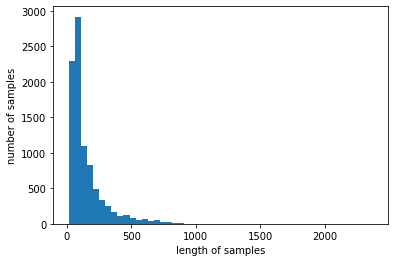

In [24]:
plt.hist([len(l) for l in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

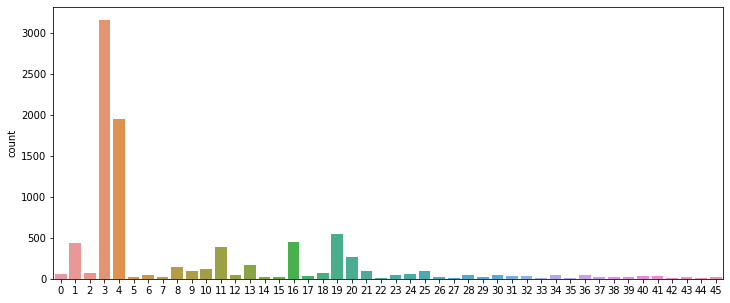

In [25]:
plt.figure(figsize=(12,5))
sns.countplot(y_train)
plt.show()

### LSTM으로 로이터 뉴스 분류
- 단어: 빈도수 기준 1,000 단어 (총 단어수 30,979)
- 문장길이: 100 단어까지 (최대 2,376)

In [28]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=1000, test_split=0.2
)

In [29]:
# 모델의 입력으로 사용되는 모든 뉴스 기사의 길이를 동일하게 100으로 맞춤
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [30]:
# 뉴스 기사 레이블의 원-핫 인코딩
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [31]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 100), (2246, 100), (8982, 46), (2246, 46))

In [32]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [33]:
model = Sequential([ 
    Embedding(1000, 100),
    LSTM(120),
    Dense(category, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         100000    
_________________________________________________________________
lstm (LSTM)                  (None, 120)               106080    
_________________________________________________________________
dense (Dense)                (None, 46)                5566      
Total params: 211,646
Trainable params: 211,646
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

In [35]:
# Callback 함수
model_file = 'model/best_reuter_lstm.h5'
mc = ModelCheckpoint(model_file, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

In [36]:
history = model.fit(
    X_train, Y_train, batch_size=100, epochs=50,
    validation_split=0.2, verbose=2, callbacks=[mc, es]
)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 2.40501, saving model to model\best_reuter_lstm.h5
72/72 - 8s - loss: 2.6404 - accuracy: 0.3447 - val_loss: 2.4050 - val_accuracy: 0.3450
Epoch 2/50

Epoch 00002: val_loss improved from 2.40501 to 2.02390, saving model to model\best_reuter_lstm.h5
72/72 - 7s - loss: 2.1645 - accuracy: 0.4470 - val_loss: 2.0239 - val_accuracy: 0.4964
Epoch 3/50

Epoch 00003: val_loss improved from 2.02390 to 1.92908, saving model to model\best_reuter_lstm.h5
72/72 - 7s - loss: 1.9706 - accuracy: 0.5105 - val_loss: 1.9291 - val_accuracy: 0.5303
Epoch 4/50

Epoch 00004: val_loss improved from 1.92908 to 1.72257, saving model to model\best_reuter_lstm.h5
72/72 - 7s - loss: 1.7992 - accuracy: 0.5427 - val_loss: 1.7226 - val_accuracy: 0.5609
Epoch 5/50

Epoch 00005: val_loss improved from 1.72257 to 1.70887, saving model to model\best_reuter_lstm.h5
72/72 - 7s - loss: 1.7217 - accuracy: 0.5620 - val_loss: 1.7089 - val_accuracy: 0.5604
Epoch 6/50

Epoch 0

In [37]:
best_model = load_model(model_file)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 17ms/step - loss: 1.2745 - accuracy: 0.7026


[1.2744592428207397, 0.7025823593139648]

### 학습과정 시각화
- 하나의 X축, 두개의 Y축 스케일

In [39]:
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(1, len(y_acc)+1)

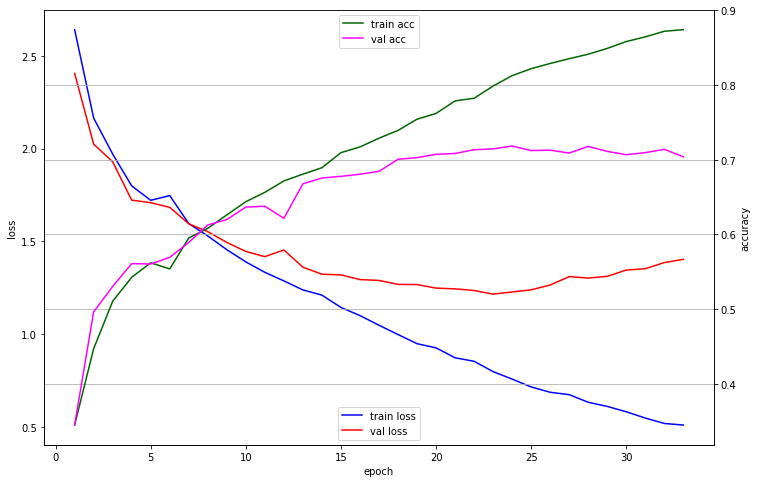

In [40]:
fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c='blue', label='train loss')
ax0.plot(x_len, y_vloss, c='red', label='val loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c='darkgreen', label='train acc')
ax1.plot(x_len, y_vacc, c='magenta', label='val acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center'); ax1.legend(loc='upper center')
plt.grid(); plt.show()